###Part 2: Putting it together

In this part we find out which Output Areas the person is likely to be in.

Previously I did this by computing a 2d spatial probability distribution by multiplying the 'donuts' which surround each landmark. I.e. the probability of being at location $X$ is the product of the probability of being at $X$'s distance from each landmark $L_i$, given we were told we were $d_i$ distance from each landmark:

$P(X|L_1, d_1, ... L_N, d_N) = \prod_i P(||X-L_i||_2 | d_i)$

For a given Output area, $OA$:

I then found $P(OA) = \sum_{X \in Range} P(OA|X,\mathbf{L})P(X|\mathbf{L})$ 

Where $P(OA|X,\mathbf{L}) = P(OA|X)$ and is just zero or one depending on which OA it is in.

So $P(OA|\mathbf{L}) = \sum_{X \in OutputArea} P(X|\mathbf{L})$

However, later when using this with the Bayesian network, I found that we were trying to infer $P(OA|age,gender)$ *and* $P(OA|\mathbf{L})$, which can't be easily accomodated together.

Dai Zhenwen made the observation that I should think about this in a more 'probabilistic' way. Specifically, I should be finding the likelihood of the reported distance from landmark $i$ being $d_i$ given we're in output area, $OA$:

$P(d_i|OA)$

Assuming these are independent (TODO: How poor is this assumption?)

$P(\mathbf{d}|OA) = \prod_i P(d_i|OA)$

$P(\mathbf{d}|OA) = \prod_i \sum_{X \in Range} P(d_i|X) P(X|OA)$

Where again P(X|OA) is contstant inside the output area and zero outside.

$P(\mathbf{d}|OA) = \left< P(d_i|X) \right>_{X \in OutputArea}$

In other words, integrate over all the points in the output area, and for each point decide how likely it is that given distance, $d_i$, was reported from landmark $i$.

Previously, we looped over all the points in an output area and decided how likely the point was, given the distances from the various landmarks.

###Data used

This code accesses:

- freegeoip.net to find lat/long of people's IP addresses
- overpass, an API to the Open Street Map dataset, to find the locations of museums
- a shape file of Output Area boundaries, provided by the ONS

First: Get their IP address, and figure out where they are.

In [2]:
import pyproj
import random
import shapefile
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.wkb import loads
import matplotlib.pyplot as plt;
%matplotlib inline
import json
import urllib2
import scipy.stats
import overpy
import numpy as np
from operator import itemgetter, attrgetter, methodcaller
from descartes import PolygonPatch

ImportError: No module named descartes

In [ ]:
ip = '143.167.150.6';
url = 'https://freegeoip.net/json/';
url = url + ip #using a different IP for testing purposes
json_loc = json.load(urllib2.urlopen(url))
print json_loc['latitude'], json_loc['longitude'], json_loc['city']

We need some landmarks to test this with, we use museums as they're unique landmarks people know.
We query the open street map 'overpass' API to get all the museums nearby.

hint: see, http://wiki.openstreetmap.org/wiki/Map_Features and http://python-overpy.readthedocs.org/en/latest/example.html

note also that the Open Street Map data is in latitude and longitude, while the ONS Output area data is in Eastings and Northings using the EPSG:27700 projection. This transform is made in this function and the east and north values added to each item.

Example, accessing the overpass results, showing some museums close to our IP address' apparent location.

In [3]:
items =overpass_query(json_loc['latitude'],json_loc['longitude'],0.1,'tourism', 'museum')
for i,item in enumerate(items):
    print "%0.3f %0.3f %0.3f %s %d" % (np.sqrt(item.distsqr),item.lat,item.lon,item.tags['name'],item.id)
    if i>3:
        break

NameError: name 'overpass_query' is not defined

We also need the ONS Output area shapes to find which ones we're in.
Previously we just loaded the shapefile, as illustrated below. But for the whole country this is far too slow.

In [235]:
import shapefile
sf = shapefile.Reader("temp_geography/england_oac_2011.shp")
shps = sf.shapes()
print "Shape bounding box:",shps[0].bbox
recs = sf.records()
print "Output area designation %s" % recs[0][1]

Shape bounding box: [435698.548, 391912.174, 436142.0, 392307.0]
Output area designation E00040849


So to make this quick it gets precached in a database.
Each row stores:

- the bounding box of each shape: bbox0,1,2,3
- the shape itself (as a json string of a list of pairs of coordinates): shape
- the record associated (also as a json string): record

The following code stores the data in a sample_outputarea.db sqlite database.

In [206]:
import json
import sqlite3 as lite
import pickle
import shapefile
sf = shapefile.Reader("temp_geography/england_oac_2011.shp")
con = lite.connect("sample_outputarea.db") 
cur = con.cursor()
cur.execute('DROP TABLE IF EXISTS boundaries')
cur.execute('CREATE TABLE IF NOT EXISTS boundaries (id INTEGER PRIMARY KEY AUTOINCREMENT, bbox0 DECIMAL(9,6), bbox1 DECIMAL(9,6), bbox2 DECIMAL(9,6), bbox3 DECIMAL(9,6), shape VARCHAR(50000), record VARCHAR(50000));')
cur.execute('CREATE INDEX bbox0 ON boundaries (bbox0);')
cur.execute('CREATE INDEX bbox1 ON boundaries (bbox1);')
cur.execute('CREATE INDEX bbox2 ON boundaries (bbox2);')
cur.execute('CREATE INDEX bbox3 ON boundaries (bbox3);')

cur.close()
con.commit()
a = []
cur = con.cursor()

for i in range(sf.numRecords):
    shp = sf.shape(i)
    rec = sf.record(i)
    bbox= shp.bbox
    shpstring = json.dumps([[p[0],p[1]] for p in shp.points])
    recstring = json.dumps(rec)
    cur.execute('INSERT INTO boundaries (bbox0, bbox1, bbox2, bbox3, shape, record) VALUES (?,?,?,?,?,?)',(bbox[0],bbox[1],bbox[2],bbox[3],shpstring,recstring));
cur.close()
con.commit()
con.close()

###Example

We imagine we're at a location (somewhere near the mean location of the first 5 landmarks in the list, as an example). I've shortened the list to 5 and assumed these are landmarks we know the distance to.

In [241]:
pos_east = 0
pos_north = 0
items = items[:5]
#Hopefully there are at least 5 landmarks.
for it in items:
    pos_east += it.east / 5.
    pos_north += it.north / 5.
    
import numpy as np
pos_east += np.random.randn()*2
pos_north += np.random.randn()*2

for it in items:
    it.dist = ((pos_east - it.east)**2 + (pos_north - it.north)**2)**.5
    it.dist += it.dist * np.random.randn()*.1 #dist is the reported distance to the landmark

bbox[0] = min([it.east for it in items]);
bbox[1] = min([it.north for it in items]);
bbox[2] = max([it.east for it in items]);
bbox[3] = max([it.north for it in items]);
margin = (bbox[3]+bbox[2]-bbox[1]-bbox[0])/4.
bbox[0] -= margin
bbox[1] -= margin
bbox[2] += margin
bbox[3] += margin

for it in items:
    print it.dist, it.tags['name']

2042.66774662 Traditional Heritage Museum
763.025221474 Weston Park Museum
879.663913748 National Emergency Services Museum
979.87706437 Millennium Gallery
1126.10313251 Kelham Island Industrial Museum


428


In [243]:
import numpy as np
from scipy.stats import norm

con = lite.connect("sample_outputarea.db") 
cur = con.cursor()

tempbbox = bbox
results = cur.execute("SELECT record, shape FROM boundaries WHERE bbox2>? AND bbox0<? AND bbox3>? AND bbox1<?",(tempbbox[0],tempbbox[2],tempbbox[1],tempbbox[3]))
shps = []
recs = []
for res in results:
    shp_points = json.loads(res[1])
    rec = json.loads(res[0])
    shps.append(Polygon(shp_points))
    recs.append(rec)
print len(recs)
cur.close()
con.close()


ps = []
for shp in shps:
    prob = 0
    count = 0
    for e in np.arange(shp.bounds[0],shp.bounds[2],(shp.bounds[2]-shp.bounds[0])/5.):
        for n in np.arange(shp.bounds[1],shp.bounds[3],(shp.bounds[3]-shp.bounds[1])/5.):
            pnt = Point(e,n)
            if pnt.within(shp):
                p = 1
                for it in items:
                #we want p(distance_to_each_landmark|location)
                #if we find the average of these inside the OA, we'll have p(distance|OA) = SUM[ p(dist|loc)p(loc|OA) ]
                #p(loc|OA) is either 1/number_of_locs_in_OA or 0.
                    dist = ((e - it.east)**2 + (n - it.north)**2)**.5
                    p *= norm.pdf(dist,it.dist,it.dist*0.1)
                    count += 1
                    #if (p>0.0001):
                    #    print "%0.0f %0.0f: %0.0f %0.0f, %0.2f-%0.2f (%0.5f)" % (e,n,it.east,it.north,dist,it.dist,p)
                prob += p
    ps.append(prob/count)
max(ps)

1.9706544747793437e-14

Plot the locations of the landmarks, circle to indicate the belief in the distance from each, and the output areas, shaded with each one's conditional probability, $P(distances|output area)$ (white=0)

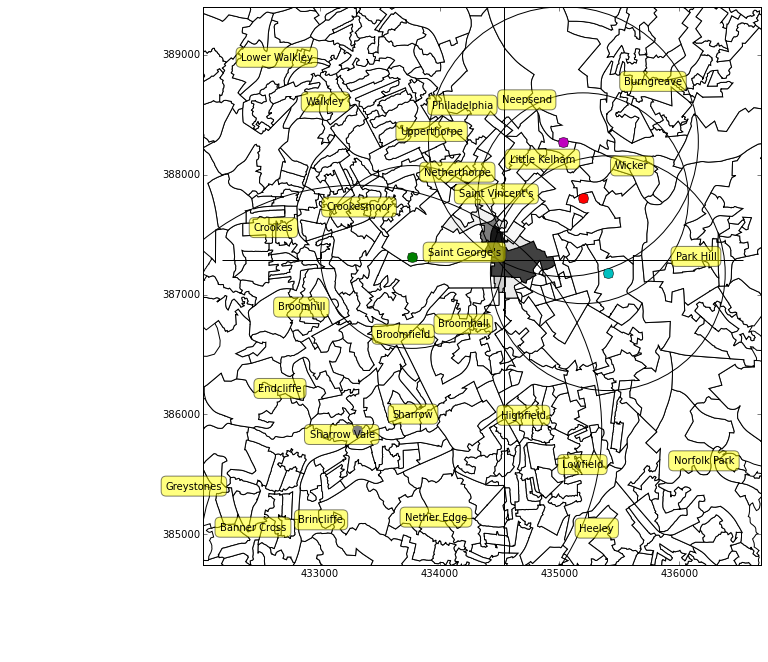

In [247]:
#import matplotlib.patches as patches
%matplotlib inline
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

places =overpass_query(json_loc['latitude'],json_loc['longitude'],0.1,'place', 'suburb')
labels = [p.tags['name'] for p in places]
place_xs = [p.east for p in places]
place_ys = [p.north for p in places]


totalP = ps
#totalP = [p/s.area for p,s in zip(ps,shps)]
totalP = totalP / np.max(totalP) #normalise

for p,shp in zip(totalP,shps): 
    c=[1-p*.9]*3
    patch = PolygonPatch(shp, fc=c, ec='#000000', fill=True, zorder=-1)
    ax.add_patch(patch)
    #plt.plot(shp.points[0][0],shp.points[0][1],'x')
plt.axes().set_aspect('equal', 'datalim')

for it in items:
    plt.plot(it.east,it.north,'o',markersize=10)
    c=plt.Circle((it.east,it.north),it.dist,fill=False,color='k')
    plt.gcf().gca().add_artist(c)
#Plot place names
for label, x, y in zip(labels,place_xs,place_ys):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (0, 0),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5))
        
plt.xlim(bbox[0],bbox[2])
plt.ylim(bbox[1],bbox[3])

plt.vlines(pos_east,bbox[1],bbox[3])
plt.hlines(pos_north,bbox[0],bbox[2])


Previously I had to correct for the **AREA** of each Output Area, because the OAs were summed probabilities of being at each point, given the distances. Normally one wouldn't need to normalise, but we know, apriori that the populations of the output areas are approximately equal, so this needs correcting for.

With the new inference calculation, this correction is already inbuilt by multiplying by $P(OA|X)$ which effectively does this: We effectively find the mean of the probabilities for all the points in the Output Area, so the actual size of the output area doesn't have any effect.

###Summary

The method described above provides $P(landmark distances|output area)$ rather than $P(output area|landmark distances)$. This has the great advantage that it can now be combined in the Bayesian network with $P(output area|age,gender)$.